In [170]:
# This Jupyter Notebook does feature engineering joining all features in all tables.

import matplotlib.pyplot as plt
import pandas as pd
import seaborn

# Read employees dataset
df_employee_raw = pd.read_csv('data/employees4.csv', na_values=['\\N'], on_bad_lines='skip', infer_datetime_format=True, parse_dates=['Date_Joined', 'Date_Resigned', 'Inactive_Date'])
df_employee_raw.info()
print(f'Total employees {str(df_employee_raw["Employee_Code"].nunique())}')
print(f'Earliest join date {str(df_employee_raw["Date_Joined"].min())}')
print(f'Latest join date {str(df_employee_raw["Date_Joined"].max())}')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1261 entries, 0 to 1260
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Employee_No          1261 non-null   int64         
 1   Employee_Code        1261 non-null   int64         
 2   Name                 1261 non-null   object        
 3   Title                1261 non-null   object        
 4   Address_Line_1       1261 non-null   object        
 5   Address_Line_2       1181 non-null   object        
 6   Address_Line_3       952 non-null    object        
 7   Date_of_Birth        1261 non-null   object        
 8   Gender               1261 non-null   object        
 9   Religion_ID          1261 non-null   int64         
 10  Marital_Status       1170 non-null   object        
 11  Designation_ID       1261 non-null   int64         
 12  Date_Joined          1261 non-null   datetime64[ns]
 13  Date_Resigned        955 non-null

In [171]:
# Clean employee table
# Drop Employee_Code because it's not referenced in other tables.
df_employee = df_employee_raw.drop('Employee_Code', axis=1)
# We start analysis from 2020-02-01 from when the attendance system is properly implemented at the given organization.
start_time = pd.to_datetime('2020-02-01 00:00:00')
date_range = (df_employee['Date_Joined'] >= start_time)
df_employee = df_employee.loc[date_range]
df_employee

,Employee_No,Name,Title,Address_Line_1,Address_Line_2,Address_Line_3,Date_of_Birth,Gender,Religion_ID,Marital_Status,...,Date_Resigned,Status,Status_Reason,Inactive_Date,Reporting_emp_1,Reporting_emp_2,Employment_Category,Employment_Type,Religion,Designation
58,426,Thea Gaylord,Mr,"109/ A,","Konakagala Road,",Alawathugoda.,1962-05-10,Male,1,Married,...,2021-10-26,Inactive,RESIGN,2021-10-26,NaN,NaN,Staff,Contarct Basis,Buddhist,Sociologist
73,450,Mrs. Eliza O'Kon I,Mr,"No 114,","Yaya 10,Maha Ambagaswewa,",Medirigiriya.,1976-05-27,Male,1,Married,...,2021-04-09,Inactive,RESIGN,2021-04-09,NaN,NaN,Labour,Contarct Basis,Buddhist,Unskilled Labor
78,457,Saul Marquardt,Mr,"Kodiyabandawewa,",Atweeragollewa.,NaN,1967-03-20,Male,1,Married,...,NaN,Inactive,Resign,2020-09-25,NaN,NaN,Labour,Contarct Basis,Buddhist,Unskilled Labor
79,460,Monica Wunsch,Mr,"Attaweeragollawe,",Madawachchiya.,NaN,1955-03-10,Male,1,Married,...,0000-00-00,Inactive,Resign,2020-03-31,NaN,NaN,Labour,Contarct Basis,Buddhist,Semi Skilled Labor
83,471,Miss Naomie Swaniawski II,Mr,33,Piyasaragama,"Boropola, Mahaoya.",1992-08-16,Male,1,Single,...,2022-02-28,Inactive,RESIGN,2022-02-28,NaN,NaN,Labour,Contarct Basis,Buddhist,Skilled Labor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,2836,Janis Borer Jr.,Ms,"No 339,","Kotte Road,",Nugegoda.,1993-03-23,Female,1,Single,...,2022-12-22,Inactive,Resign,2022-12-22,NaN,NaN,Staff,Contarct Basis,Buddhist,Account Executive
1257,2890,Delphia Haley,Mr,"No 267/3,Dhammananda Mawatha,Pahala Beligala,B...",NaN,NaN,1994-10-06,Male,1,Single,...,0000-00-00,Active,NaN,0000-00-00,NaN,NaN,Staff,Contarct Basis,Buddhist,Quantity Surveyor
1258,2972,Lance Stanton,Mr,"No 255/2,Jathika Niwasa,Arangala,Naula,matale.",NaN,NaN,1997-01-02,Male,1,Single,...,NaN,Active,NaN,NaN,NaN,NaN,Staff,Contarct Basis,Buddhist,Software Developer
1259,2973,Chauncey Reilly,Mr,"No 15/B,Badulla Road,Demodara",NaN,NaN,1990-08-16,Male,1,Single,...,0000-00-00,Active,NaN,0000-00-00,NaN,NaN,Staff,Contarct Basis,Buddhist,Quantity Surveyor


In [172]:
df_employee['Date_Joined'].describe()

/tmp/ipykernel_100137/3760665125.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_employee['Date_Joined'].describe()


count                     796
unique                    369
top       2021-02-01 00:00:00
freq                       23
first     2020-02-01 00:00:00
last      2022-12-20 00:00:00
Name: Date_Joined, dtype: object

In [173]:
# Read leaves dataset, filter out special leave categories.
df_leaves = pd.read_csv('data/leaves_clean.csv')
df_leaves = df_leaves.rename(columns={'leave_date': 'Leave_Date',
                                      'Type': 'Leave_Factor',
                                      'Applied Date': 'Applied_Date',
                                      'leave_leave_date': 'Lieu_Leave_Date',
                                      'Remarks': 'Remarks',
                                      'apply_type': 'Leave_Category'})
df_leaves_type_map = {'Half Day': 0.5, 'Full Day': 1}
df_leaves['Leave_Factor'] = df_leaves['Leave_Factor'].map(df_leaves_type_map)
df_leaves_legit = pd.DataFrame(df_leaves.loc[(df_leaves['Leave_Category'] != 'Liue Leave') & (df_leaves['Leave_Category'] != 'Curfew') & (df_leaves['Leave_Category'] != 'Sat Holiday')])
df_leaves_summary_temp = df_leaves.groupby('Employee_No')['Leave_Factor'].sum()
df_leaves_summary = pd.DataFrame({'Employee_No': df_leaves_summary_temp.index, 'Leave_Count':  df_leaves_summary_temp.values})
df_leaves_summary.head()
#df_leaves_summary

,Employee_No,Leave_Count
0,347,52.5
1,348,21.5
2,351,57.0
3,352,105.5
4,354,79.5


In [174]:
# Group two datasets

df_employee = pd.merge(df_employee, df_leaves_summary, on='Employee_No', how='left')
df_employee['Leave_Count'].fillna(0, inplace=True)
df_employee

,Employee_No,Name,Title,Address_Line_1,Address_Line_2,Address_Line_3,Date_of_Birth,Gender,Religion_ID,Marital_Status,...,Status,Status_Reason,Inactive_Date,Reporting_emp_1,Reporting_emp_2,Employment_Category,Employment_Type,Religion,Designation,Leave_Count
0,426,Thea Gaylord,Mr,"109/ A,","Konakagala Road,",Alawathugoda.,1962-05-10,Male,1,Married,...,Inactive,RESIGN,2021-10-26,NaN,NaN,Staff,Contarct Basis,Buddhist,Sociologist,11.0
1,450,Mrs. Eliza O'Kon I,Mr,"No 114,","Yaya 10,Maha Ambagaswewa,",Medirigiriya.,1976-05-27,Male,1,Married,...,Inactive,RESIGN,2021-04-09,NaN,NaN,Labour,Contarct Basis,Buddhist,Unskilled Labor,60.0
2,457,Saul Marquardt,Mr,"Kodiyabandawewa,",Atweeragollewa.,NaN,1967-03-20,Male,1,Married,...,Inactive,Resign,2020-09-25,NaN,NaN,Labour,Contarct Basis,Buddhist,Unskilled Labor,0.0
3,460,Monica Wunsch,Mr,"Attaweeragollawe,",Madawachchiya.,NaN,1955-03-10,Male,1,Married,...,Inactive,Resign,2020-03-31,NaN,NaN,Labour,Contarct Basis,Buddhist,Semi Skilled Labor,0.0
4,471,Miss Naomie Swaniawski II,Mr,33,Piyasaragama,"Boropola, Mahaoya.",1992-08-16,Male,1,Single,...,Inactive,RESIGN,2022-02-28,NaN,NaN,Labour,Contarct Basis,Buddhist,Skilled Labor,73.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,2836,Janis Borer Jr.,Ms,"No 339,","Kotte Road,",Nugegoda.,1993-03-23,Female,1,Single,...,Inactive,Resign,2022-12-22,NaN,NaN,Staff,Contarct Basis,Buddhist,Account Executive,5.0
792,2890,Delphia Haley,Mr,"No 267/3,Dhammananda Mawatha,Pahala Beligala,B...",NaN,NaN,1994-10-06,Male,1,Single,...,Active,NaN,0000-00-00,NaN,NaN,Staff,Contarct Basis,Buddhist,Quantity Surveyor,9.0
793,2972,Lance Stanton,Mr,"No 255/2,Jathika Niwasa,Arangala,Naula,matale.",NaN,NaN,1997-01-02,Male,1,Single,...,Active,NaN,NaN,NaN,NaN,Staff,Contarct Basis,Buddhist,Software Developer,4.0
794,2973,Chauncey Reilly,Mr,"No 15/B,Badulla Road,Demodara",NaN,NaN,1990-08-16,Male,1,Single,...,Active,NaN,0000-00-00,NaN,NaN,Staff,Contarct Basis,Buddhist,Quantity Surveyor,2.0


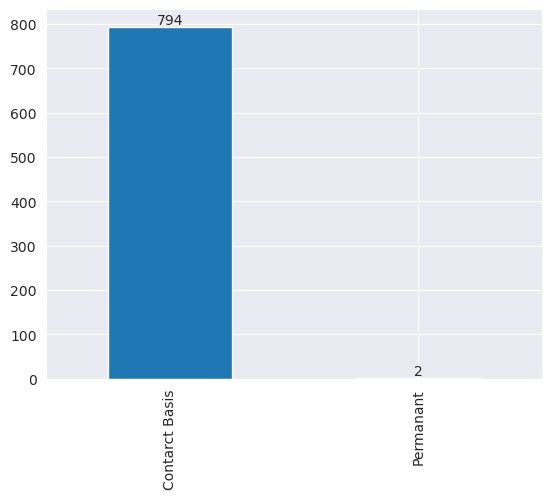

In [175]:
temp_plot = df_employee['Employment_Type'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Employment_Type'].value_counts())
plt.show()

#temp_plot = df['Designation'].value_counts().plot(kind='pie')
#plt.legend()
#plt.show()

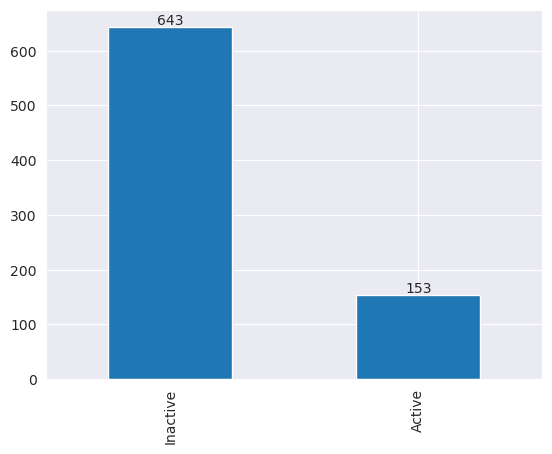

In [176]:
temp_plot = df_employee['Status'].value_counts().plot(kind='bar')
temp_plot.bar_label(temp_plot.containers[0], labels=df_employee['Status'].value_counts())
plt.show()

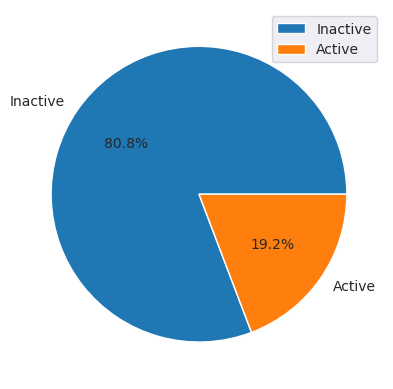

In [177]:
plt.pie(df_employee['Status'].value_counts(), labels=df_employee['Status'].unique(), autopct='%1.1f%%')
plt.legend()
plt.show()

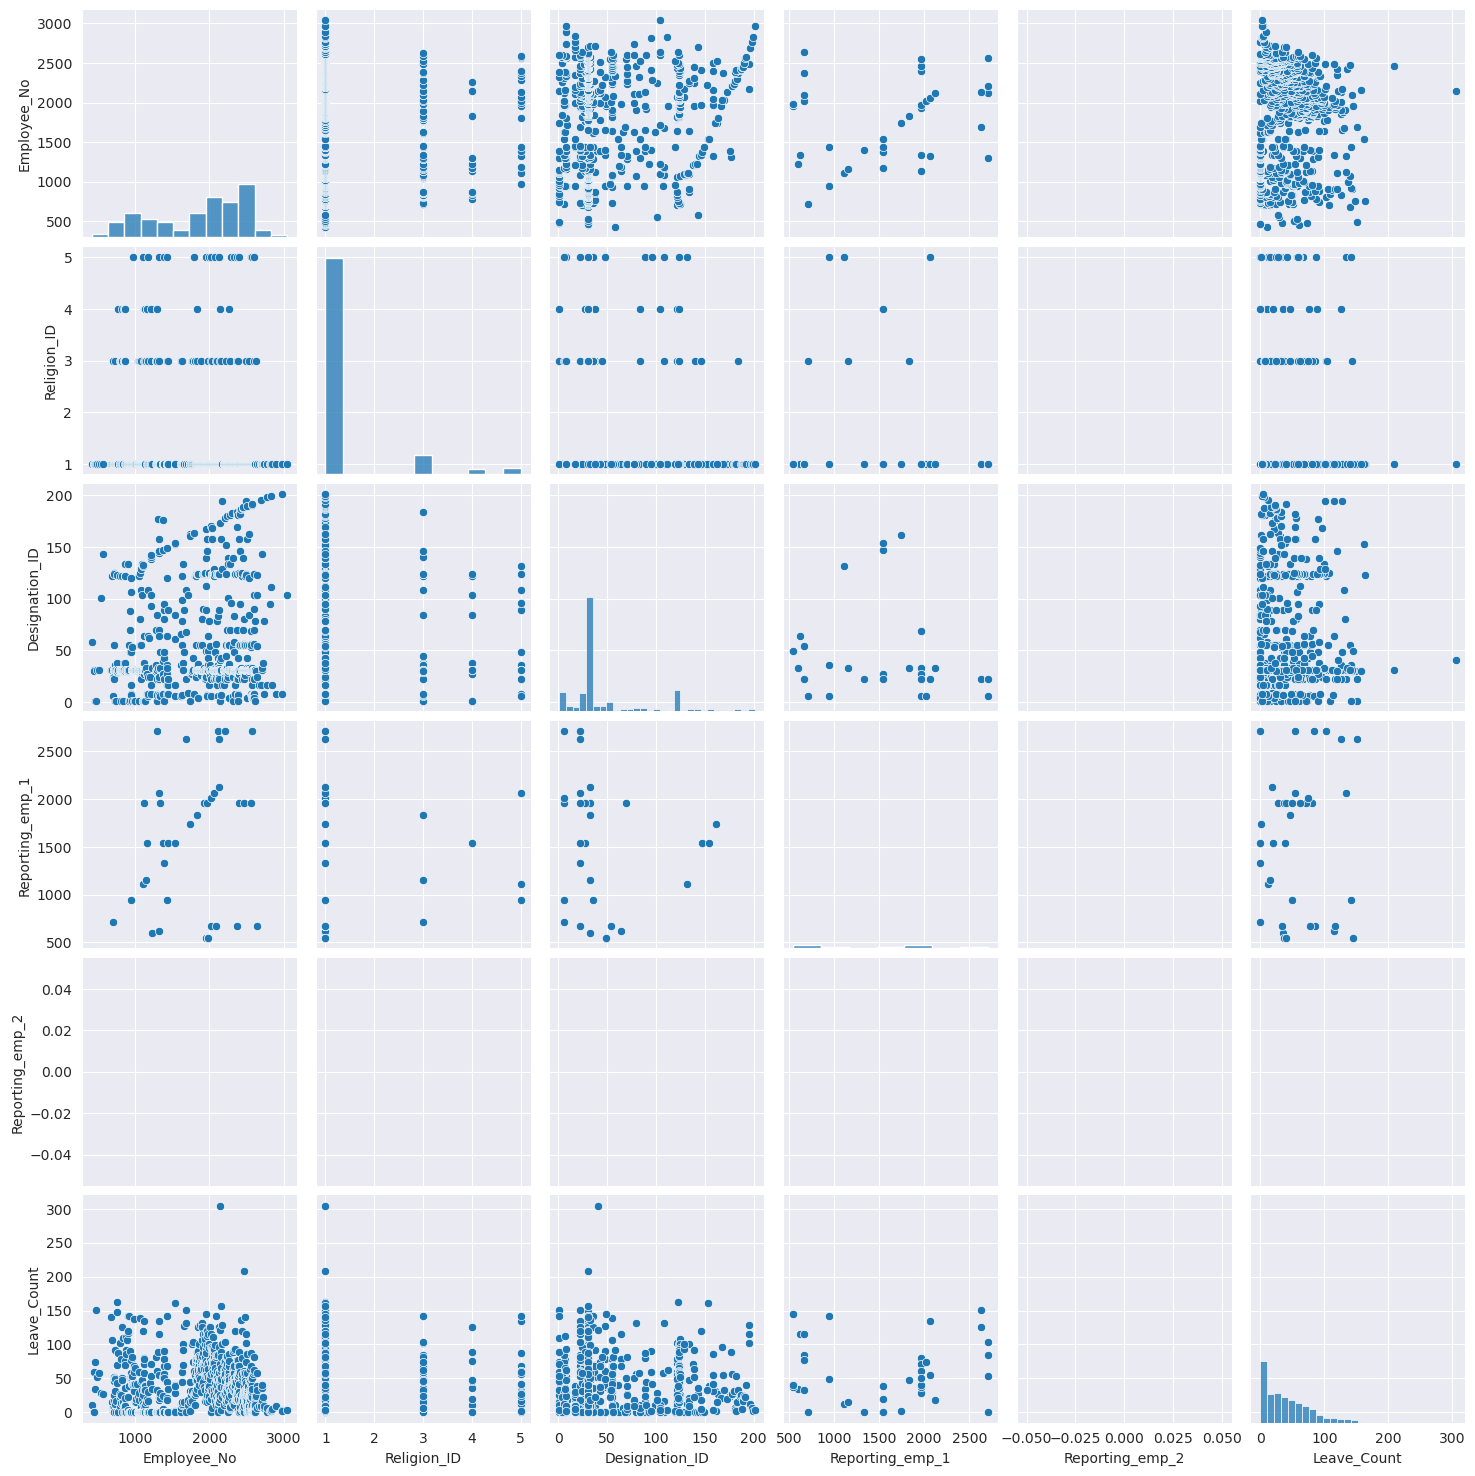

In [178]:
seaborn.pairplot(df_employee)

In [179]:
df_employee_inactive_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_inactive_contract_based['Date_Joined'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Joined'])
df_employee_inactive_contract_based['Date_Resigned'] = pd.to_datetime(df_employee_inactive_contract_based['Date_Resigned'], errors='coerce')
df_employee_inactive_contract_based['Employment_Duration'] = df_employee_inactive_contract_based['Date_Resigned'] - df_employee_inactive_contract_based['Date_Joined']
df_employee_inactive_contract_based['Employment_Duration'].describe()

count                            562
mean     220 days 11:08:45.266903916
std      189 days 11:01:45.550385808
min                  0 days 00:00:00
25%                 79 days 06:00:00
50%                173 days 00:00:00
75%                298 days 18:00:00
max                932 days 00:00:00
Name: Employment_Duration, dtype: object

In [180]:
df_employee_inactive_permanent =  pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive') & (df_employee['Employment_Type'] == 'Permanant')])
df_employee_inactive_permanent['Date_Joined'] = pd.to_datetime(df_employee_inactive_permanent['Date_Joined'])
df_employee_inactive_permanent['Date_Resigned'] = pd.to_datetime(df_employee_inactive_permanent['Date_Resigned'], errors='coerce')
df_employee_inactive_permanent['Employment_Duration'] = df_employee_inactive_permanent['Date_Resigned'] - df_employee_inactive_permanent['Date_Joined']
df_employee_inactive_permanent['Employment_Duration'].describe()

count                    1
mean     257 days 00:00:00
std                    NaT
min      257 days 00:00:00
25%      257 days 00:00:00
50%      257 days 00:00:00
75%      257 days 00:00:00
max      257 days 00:00:00
Name: Employment_Duration, dtype: object

In [181]:
df_employee_inactive = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Inactive')])
df_employee_inactive['Date_Joined'] = pd.to_datetime(df_employee_inactive['Date_Joined'])
df_employee_inactive['Date_Resigned'] = pd.to_datetime(df_employee_inactive['Date_Resigned'], errors='coerce')
df_employee_inactive['Employment_Duration'] = df_employee_inactive['Date_Resigned'] - df_employee_inactive['Date_Joined']
df_employee_inactive['Employment_Duration'].describe()

count                            563
mean     220 days 12:42:12.149200712
std      189 days 07:07:56.718433316
min                  0 days 00:00:00
25%                 79 days 12:00:00
50%                173 days 00:00:00
75%                298 days 12:00:00
max                932 days 00:00:00
Name: Employment_Duration, dtype: object

In [182]:
# Active contract base employee analysis.
from datetime import datetime
df_employee_active_contract_based = pd.DataFrame(df_employee.loc[(df_employee['Status'] == 'Active') & (df_employee['Employment_Type'] == 'Contarct Basis')])
df_employee_active_contract_based['Date_Joined'] = pd.to_datetime(df_employee_active_contract_based['Date_Joined'])
today_timestamp = pd.Timestamp(datetime.today().date())
df_employee_active_contract_based['Employment_Duration'] = today_timestamp - df_employee_active_contract_based['Date_Joined']
df_employee_active_contract_based['Employment_Duration'].describe()

count                            152
mean     513 days 21:09:28.421052632
std      258 days 03:59:08.662802828
min                 68 days 00:00:00
25%                351 days 18:00:00
50%                423 days 12:00:00
75%                592 days 12:00:00
max               1121 days 00:00:00
Name: Employment_Duration, dtype: object

In [183]:
df_employee_inactive_contract_based['Leave_Count'].describe()

count    642.000000
mean      38.199377
std       33.464746
min        0.000000
25%       10.000000
50%       32.000000
75%       58.500000
max      163.000000
Name: Leave_Count, dtype: float64

In [184]:
df_employee_active_contract_based['Leave_Count'].describe()

count    152.000000
mean      55.019737
std       50.304565
min        0.000000
25%       12.500000
50%       49.250000
75%       82.375000
max      305.000000
Name: Leave_Count, dtype: float64